## plot all products g value

In [18]:
import random
import time
import requests

time_frame = 18
check_point_sz = 3

class CPiX:
    def __init__(self):
        self.products = {}

    def initialize_product(self, product_name):
        self.products[product_name] = {
            'p_values': [0] * (1 + time_frame // 2),
            'counter': [0] * (1 + time_frame // 2),
            'c_values': [0] * (1 + time_frame // (2 * check_point_sz)),
            'g_value': 0
        }

    def update_values(self, s, product_name, new_value):
        if product_name not in self.products:
            self.initialize_product(product_name)

        product_data = self.products[product_name]
        p = ((s - 1) % time_frame) + 1
        round = (s + time_frame - 1) // time_frame
        p_index = (p + 2 - 1) // 2
        c_index = (p + 2 * check_point_sz - 1) // (2 * check_point_sz)

        if 1 <= p_index < len(product_data['p_values']):
            if round > product_data['counter'][p_index]:
                product_data['p_values'][p_index] = new_value
                product_data['counter'][p_index] = round
            elif round == product_data['counter'][p_index]:
                product_data['p_values'][p_index] = max(product_data['p_values'][p_index], new_value)

            if 1 <= c_index < len(product_data['c_values']):
                start_index = (c_index - 1) * check_point_sz + 1
                end_index = start_index + check_point_sz
                product_data['c_values'][c_index] = max(product_data['p_values'][start_index:end_index])

        product_data['g_value'] = max(product_data['c_values'][1:])

    def top_k_products(self, k):
        g_values = {product: data['g_value'] for product, data in self.products.items()}
        top_k = sorted(g_values.items(), key=lambda item: item[1], reverse=True)[:k]
        return top_k

# Initialize CPiX instance
cpix = CPiX()

def generate_unique_nearby_shuffled_sequence(length, shuffle_window=2):
    sequence = list(range(1, length + 1))
    shuffled_sequence = []
    used_seconds = set()

    for i in range(length):
        start = max(1, i - shuffle_window)
        end = min(length + 1, i + shuffle_window + 1)
        available_options = [num for num in range(start, end) if num not in used_seconds]

        if available_options:
            chosen_value = random.choice(available_options)
            shuffled_sequence.append(chosen_value)
            used_seconds.add(chosen_value)

    return shuffled_sequence

unique_nearby_shuffled_sequence = generate_unique_nearby_shuffled_sequence(40, shuffle_window=2)
products = ['Product A', 'Product B', 'Product C', 'Product D']

# Prepare both CSV files
top_k_csv = 'g_values.csv'  # Top K products
all_products_csv = 'all_products_g_values.csv'  # All products' G-values

# Write headers for both CSV files
with open(top_k_csv, 'w') as f1:
    f1.write('Time,Product,G-Value\n')  # Header for top-k G-values

with open(all_products_csv, 'w') as f2:
    f2.write('Time,' + ','.join(products) + '\n')  # Header for all product G-values

def fetch_real_world_data(product_name):
    url = f'https://jsonplaceholder.typicode.com/posts/{random.randint(1, 50)}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        print(f"Fetched data for {product_name}: {data}")
        return data['id']
    else:
        return random.randint(1, 100)

# Process each time step and store data in both CSVs
for s in unique_nearby_shuffled_sequence:
    g_values_row = [s]  # Row for all_products_g_values.csv

    # Collect G-values for each product
    for product in products:
        value = fetch_real_world_data(product)  # Fetch real-world data
        cpix.update_values(s, product, value)  # Update product data
        g_value = cpix.products[product]['g_value']
        g_values_row.append(g_value)  # Add G-value to row

    # Write the current time step's G-values to all_products_g_values.csv
    with open(all_products_csv, 'a') as f2:
        f2.write(','.join(map(str, g_values_row)) + '\n')

    # Get the top K products and write to g_values.csv
    top_k = cpix.top_k_products(1)  # Get top 1 product based on G-value
    with open(top_k_csv, 'a') as f1:
        for product, g_value in top_k:
            f1.write(f"{s},{product},{g_value}\n")

    # Print progress summary for this time step
    print(f"After update at time {s}s:")
    for product, g_value in top_k:
        print(f"{product}: G-value = {g_value}")
    print("-" * 30)

    time.sleep(1)  # Delay for 1 second

print(f"Data has been successfully recorded in {top_k_csv} and {all_products_csv}.")


Fetched data for Product A: {'userId': 4, 'id': 36, 'title': 'fuga nam accusamus voluptas reiciendis itaque', 'body': 'ad mollitia et omnis minus architecto odit\nvoluptas doloremque maxime aut non ipsa qui alias veniam\nblanditiis culpa aut quia nihil cumque facere et occaecati\nqui aspernatur quia eaque ut aperiam inventore'}
Fetched data for Product B: {'userId': 2, 'id': 14, 'title': 'voluptatem eligendi optio', 'body': 'fuga et accusamus dolorum perferendis illo voluptas\nnon doloremque neque facere\nad qui dolorum molestiae beatae\nsed aut voluptas totam sit illum'}
Fetched data for Product C: {'userId': 4, 'id': 36, 'title': 'fuga nam accusamus voluptas reiciendis itaque', 'body': 'ad mollitia et omnis minus architecto odit\nvoluptas doloremque maxime aut non ipsa qui alias veniam\nblanditiis culpa aut quia nihil cumque facere et occaecati\nqui aspernatur quia eaque ut aperiam inventore'}
Fetched data for Product D: {'userId': 1, 'id': 10, 'title': 'optio molestias id quia eum',

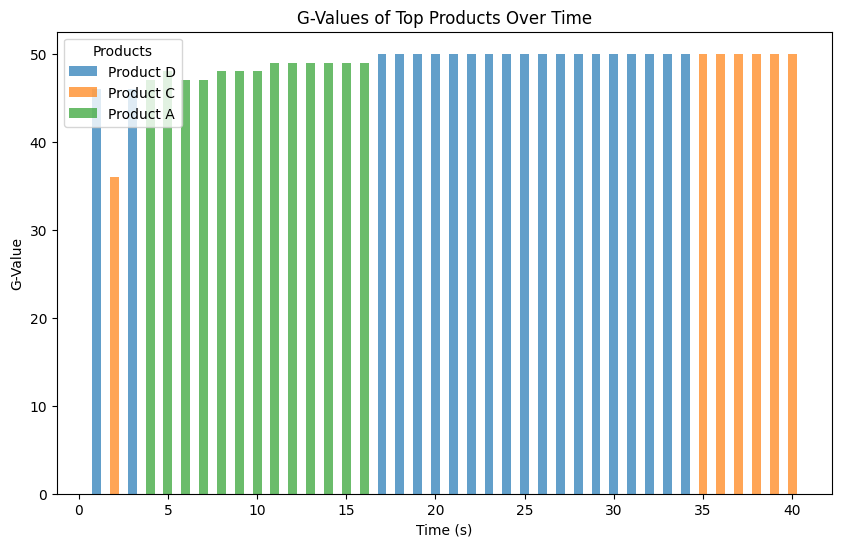

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from the CSV file
csv_file = 'g_values.csv'
data = pd.read_csv(csv_file)

# Group by time and product to find the latest G-value for each product at each time point
grouped_data = data.groupby(['Time', 'Product']).last().reset_index()

# Plot the G-values as a bar chart over time
def plot_g_values(grouped_data):
    # Get the list of unique products
    products = grouped_data['Product'].unique()

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars for each product's G-values over time
    for product in products:
        product_data = grouped_data[grouped_data['Product'] == product]
        ax.bar(product_data['Time'], product_data['G-Value'], label=product, width=0.5, alpha=0.7)

    # Customize the plot
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('G-Value')
    ax.set_title('G-Values of Top Products Over Time')
    ax.legend(title='Products')

    # Display the plot
    plt.show()

# Call the function to plot G-values
plot_g_values(grouped_data)


<ipython-input-19-483b08dde1ba>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(products))  # Tab10 colormap for distinct colors


Predicted G-Value for Product A at time 41: 50.51
Predicted G-Value for Product B at time 41: 50.37
Predicted G-Value for Product C at time 41: 52.76
Predicted G-Value for Product D at time 41: 53.84


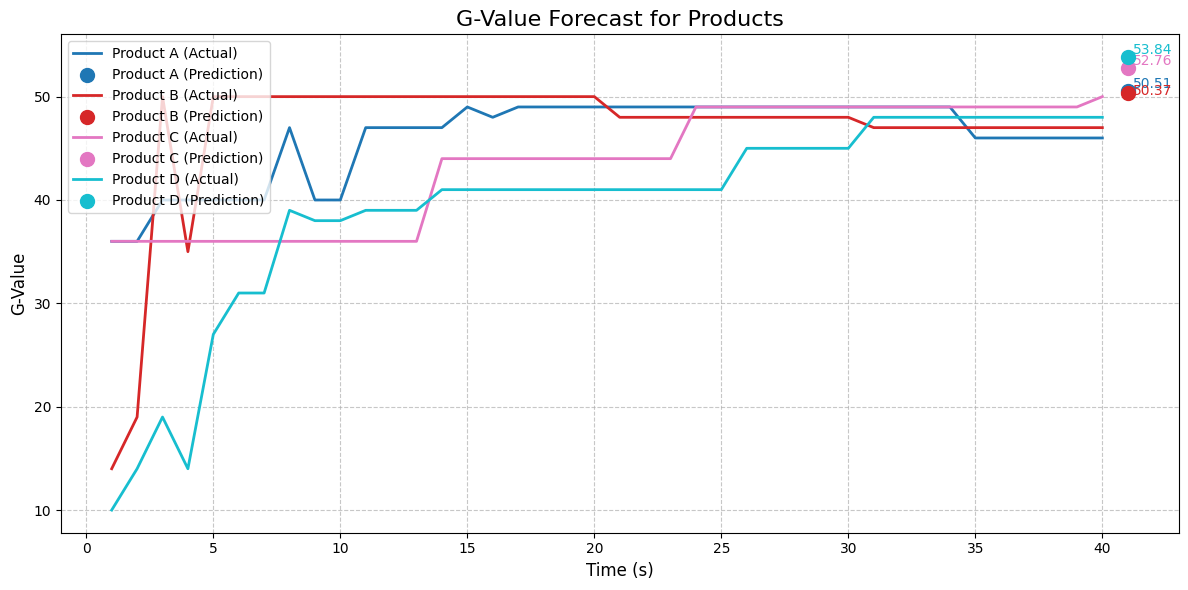

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Load data from the CSV file
data = pd.read_csv('all_products_g_values.csv')

# Sort data by the 'Time' column to ensure correct plotting and predictions
data = data.sort_values(by='Time')

# Ensure there are no NaN values
data = data.fillna(0)

# Function to predict the next G-values and plot them
def predict_next_g_values(data):
    products = data.columns[1:]  # Exclude the 'Time' column

    plt.figure(figsize=(12, 6))  # Create the plot

    # Use a colormap to assign unique colors to each product
    colors = plt.cm.get_cmap('tab10', len(products))  # Tab10 colormap for distinct colors

    # Track the y-positions of previous annotations to prevent overlap
    annotation_positions = []

    for idx, product in enumerate(products):
        X = data[['Time']].values  # 2D array for X
        y = data[product].values   # 1D array for y

        # Train the linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Predict the next G-value for the next time step
        next_time = X[-1, 0] + 1  # Last time step + 1
        predicted_value = model.predict([[next_time]])

        # Plot the actual G-values with respective color
        plt.plot(data['Time'], y, label=f'{product} (Actual)', color=colors(idx), linestyle='-', linewidth=2)

        # Plot the predicted G-value with the same color as the product line
        plt.scatter([next_time], [predicted_value], color=colors(idx), s=100, label=f'{product} (Prediction)', zorder=5)

        # Determine y-offset to avoid overlapping annotations
        y_offset = 0.5 * (-1) ** idx  # Alternate offset direction for better spacing

        # Avoid collisions with previous annotations by checking distances
        adjusted_y = predicted_value[0]
        for pos in annotation_positions:
            if abs(pos - adjusted_y) < 1:  # Adjust if close to an existing label
                adjusted_y += y_offset

        annotation_positions.append(adjusted_y)

        # Add text annotation for the predicted value with adjusted y-position
        plt.text(next_time + 0.2, adjusted_y, f'{predicted_value[0]:.2f}',
                 fontsize=10, ha='left', va='bottom', color=colors(idx))

        # Print the prediction result to the console
        print(f'Predicted G-Value for {product} at time {next_time}: {predicted_value[0]:.2f}')

    # Customize the plot
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('G-Value', fontsize=12)
    plt.title('G-Value Forecast for Products', fontsize=16)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()

# Call the function to predict and plot the G-values
predict_next_g_values(data)
